# Load CSV files with `CSV Datasets`

This tutorial shows how to load data from CSV files based on the `CSVDataset` and `CSVIterableDataset` modules. And execute post-processing logic on the data.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/csv_datasets.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pandas, pillow]"
%matplotlib inline

## Setup imports

In [61]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import tempfile
import shutil
import sys
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import numpy as np

from monai.data import CSVDataset, CSVIterableDataset, DataLoader
from monai.apps import download_and_extract
from monai.config import print_config
from monai.transforms import Compose, LoadImaged, ToNumpyd
from monai.utils import first

print_config()

MONAI version: 0.4.0+507.g919c88e9
Numpy version: 1.21.0
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 919c88e9f636b5f63d3fa8a3527789df15526c12

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.2.0
Tensorboard version: 1.15.0+nv
gdown version: 3.13.0
TorchVision version: 0.9.0a0
ITK version: 5.1.2
tqdm version: 4.53.0
lmdb version: 1.1.1
psutil version: 5.8.0
pandas version: 1.1.4

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Download dataset

Here we use several images of MedNIST dataset in the demo. Downloads and extracts the dataset.

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

In [5]:
resource = "https://drive.google.com/uc?id=13MhoPsNgI6qboJfLicFf_jNvsFUbIYsd"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Plot several medical images in the hand category

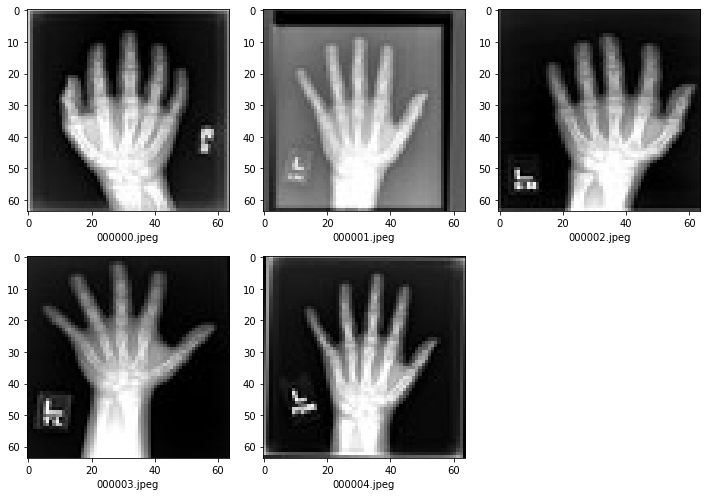

In [51]:
plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    filename = f"00000{i}.jpeg"
    im = PIL.Image.open(os.path.join(data_dir, "Hand", filename))
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(filename)
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Generate 3 CSV files for test
Here we generate 3 CSV files to store properties of the images, contains missing values.

In [19]:
test_data1 = [
    ["subject_id", "label", "image", "ehr_0", "ehr_1", "ehr_2"],
    ["s000000", 5, os.path.join(data_dir, "Hand", "000000.jpeg"), 2.007843256, 2.29019618, 2.054902077],
    ["s000001", 0, os.path.join(data_dir, "Hand", "000001.jpeg"), 6.839215755, 6.474509716, 5.862744808],
    ["s000002", 4, os.path.join(data_dir, "Hand", "000002.jpeg"), 3.772548914, 4.211764812, 4.635294437],
    ["s000003", 1, os.path.join(data_dir, "Hand", "000003.jpeg"), 3.333333254, 3.235294342, 3.400000095],
    ["s000004", 9, os.path.join(data_dir, "Hand", "000004.jpeg"), 6.427451134, 6.254901886, 5.976470947],
]
test_data2 = [
    ["subject_id", "ehr_3", "ehr_4", "ehr_5", "ehr_6", "ehr_7", "ehr_8"],
    ["s000000", 3.019608021, 3.807843208, 3.584313869, 3.141176462, 3.1960783, 4.211764812],
    ["s000001", 5.192157269, 5.274509907, 5.250980377, 4.647058964, 4.886274338, 4.392156601],
    ["s000002", 5.298039436, 9.545097351, 12.57254887, 6.799999714, 2.1960783, 1.882352948],
    ["s000003", 3.164705753, 3.086274624, 3.725490093, 3.698039293, 3.698039055, 3.701960802],
    ["s000004", 6.26274538, 7.717647076, 9.584313393, 6.082352638, 2.662744999, 2.34117651],
]
test_data3 = [
    ["subject_id", "ehr_9", "ehr_10", "meta_0", "meta_1", "meta_2"],
    ["s000000", 6.301961422, 6.470588684, "TRUE", "TRUE", "TRUE"],
    ["s000001", 5.219608307, 7.827450752, "FALSE", "TRUE", "FALSE"],
    ["s000002", 1.882352948, 2.031372547, "TRUE", "FALSE", "TRUE"],
    ["s000003", 3.309803963, 3.729412079, "FALSE", "FALSE", "TRUE"],
    ["s000004", 2.062745094, 2.34117651, "FALSE", "TRUE", "TRUE"],
    # generate missing values in the row
    ["s000005", 3.353655643, 1.675674543, "TRUE", "TRUE", "FALSE"],
]


def prepare_csv_file(data, filepath):
    with open(filepath, "w") as f:
        for d in data:
            f.write((",".join([str(i) for i in d])) + "\n")


filepath1 = os.path.join(data_dir, "test_data1.csv")
filepath2 = os.path.join(data_dir, "test_data2.csv")
filepath3 = os.path.join(data_dir, "test_data3.csv")
prepare_csv_file(test_data1, filepath1)
prepare_csv_file(test_data2, filepath2)
prepare_csv_file(test_data3, filepath3)

## Load a single CSV file with `CSVDataset`

In [25]:
dataset = CSVDataset(filename=filepath1)
# construct pandas table to show the data, `CSVDataset` inherits from PyTorch Dataset
print(pd.DataFrame(dataset.data))

  subject_id  label                                             image  \
0    s000000      5  /workspace/data/medical/MedNIST/Hand/000000.jpeg   
1    s000001      0  /workspace/data/medical/MedNIST/Hand/000001.jpeg   
2    s000002      4  /workspace/data/medical/MedNIST/Hand/000002.jpeg   
3    s000003      1  /workspace/data/medical/MedNIST/Hand/000003.jpeg   
4    s000004      9  /workspace/data/medical/MedNIST/Hand/000004.jpeg   

      ehr_0     ehr_1     ehr_2  
0  2.007843  2.290196  2.054902  
1  6.839216  6.474510  5.862745  
2  3.772549  4.211765  4.635294  
3  3.333333  3.235294  3.400000  
4  6.427451  6.254902  5.976471  


## Load multiple CSV files and join the tables

In [27]:
dataset = CSVDataset([filepath1, filepath2, filepath3], on="subject_id")
# construct pandas table to show the joined data of 3 tables
print(pd.DataFrame(dataset.data))

  subject_id  label                                             image  \
0    s000000      5  /workspace/data/medical/MedNIST/Hand/000000.jpeg   
1    s000001      0  /workspace/data/medical/MedNIST/Hand/000001.jpeg   
2    s000002      4  /workspace/data/medical/MedNIST/Hand/000002.jpeg   
3    s000003      1  /workspace/data/medical/MedNIST/Hand/000003.jpeg   
4    s000004      9  /workspace/data/medical/MedNIST/Hand/000004.jpeg   

      ehr_0     ehr_1     ehr_2     ehr_3     ehr_4      ehr_5     ehr_6  \
0  2.007843  2.290196  2.054902  3.019608  3.807843   3.584314  3.141176   
1  6.839216  6.474510  5.862745  5.192157  5.274510   5.250980  4.647059   
2  3.772549  4.211765  4.635294  5.298039  9.545097  12.572549  6.800000   
3  3.333333  3.235294  3.400000  3.164706  3.086275   3.725490  3.698039   
4  6.427451  6.254902  5.976471  6.262745  7.717647   9.584313  6.082353   

      ehr_7     ehr_8     ehr_9    ehr_10  meta_0  meta_1  meta_2  
0  3.196078  4.211765  6.301961  6.4

## Only load selected rows and selected columns from 3 CSV files
Here we load rows: 0 - 1 and 3, columns: "subject_id", "label", "ehr_1", "ehr_7", "meta_1".

In [29]:
dataset = CSVDataset(
    filename=[filepath1, filepath2, filepath3],
    row_indices=[[0, 2], 3],  # load row: 0, 1, 3
    col_names=["subject_id", "label", "ehr_1", "ehr_7", "meta_1"],
)
# construct pandas table to show the joined and selected data
print(pd.DataFrame(dataset.data))

  subject_id  label     ehr_1     ehr_7  meta_1
0    s000000      5  2.290196  3.196078    True
1    s000001      0  6.474510  4.886274    True
2    s000003      1  3.235294  3.698039   False


## Load and group columns to generate new columns
Here we load 3 CSV files and group all the `ehr_*` columns to generate a new `ehr` column, and group all the `meta_*` columns to generate a new `meta` column.

In [33]:
dataset = CSVDataset(
    filename=[filepath1, filepath2, filepath3],
    col_names=["subject_id", "image", *[f"ehr_{i}" for i in range(11)], "meta_0", "meta_1", "meta_2"],
    col_groups={"ehr": [f"ehr_{i}" for i in range(11)], "meta": ["meta_0", "meta_1", "meta_2"]},
)
# construct pandas table to show the joined, selected and generated data
print(pd.DataFrame(dataset.data))

  subject_id                                             image     ehr_0  \
0    s000000  /workspace/data/medical/MedNIST/Hand/000000.jpeg  2.007843   
1    s000001  /workspace/data/medical/MedNIST/Hand/000001.jpeg  6.839216   
2    s000002  /workspace/data/medical/MedNIST/Hand/000002.jpeg  3.772549   
3    s000003  /workspace/data/medical/MedNIST/Hand/000003.jpeg  3.333333   
4    s000004  /workspace/data/medical/MedNIST/Hand/000004.jpeg  6.427451   

      ehr_1     ehr_2     ehr_3     ehr_4      ehr_5     ehr_6     ehr_7  \
0  2.290196  2.054902  3.019608  3.807843   3.584314  3.141176  3.196078   
1  6.474510  5.862745  5.192157  5.274510   5.250980  4.647059  4.886274   
2  4.211765  4.635294  5.298039  9.545097  12.572549  6.800000  2.196078   
3  3.235294  3.400000  3.164706  3.086275   3.725490  3.698039  3.698039   
4  6.254902  5.976471  6.262745  7.717647   9.584313  6.082353  2.662745   

      ehr_8     ehr_9    ehr_10  meta_0  meta_1  meta_2  \
0  4.211765  6.301961  6.47

## Load and fill the missing values and convert data types
In this tutorial, the `s000005` image has many missing values in CSV file1 and file2. Here we select some columns and set the default value to the missing value of `image` column, and also try to convert `ehr_1` to `int` type.

In [44]:
dataset = CSVDataset(
    filename=[filepath1, filepath2, filepath3],
    col_names=["subject_id", "label", "ehr_0", "ehr_1", "ehr_9", "meta_1"],
    col_types={"label": {"default": "No label"}, "ehr_1": {"type": int, "default": 0}},
    how="outer",  # will load the NaN values in this merge mode
)
# construct pandas table to show the joined, selected and converted data
print(pd.DataFrame(dataset.data))

  subject_id     label     ehr_0  ehr_1     ehr_9  meta_1
0    s000000         5  2.007843      2  6.301961    True
1    s000001         0  6.839216      6  5.219608    True
2    s000002         4  3.772549      4  1.882353   False
3    s000003         1  3.333333      3  3.309804   False
4    s000004         9  6.427451      6  2.062745    True
5    s000005  No label       NaN      0  3.353656    True


## Execute transforms on the loaded data
Here we load the JPG image from the `image` value, and convert `ehr` group to numpy array.

<class 'numpy.ndarray'> [2.00784326 2.29019618 2.05490208 3.01960802 3.80784321]
<class 'numpy.ndarray'> [6.83921575 6.47450972 5.86274481 5.19215727 5.27450991]
<class 'numpy.ndarray'> [3.77254891 4.21176481 4.63529444 5.29803944 9.54509735]
<class 'numpy.ndarray'> [3.33333325 3.23529434 3.4000001  3.16470575 3.08627462]
<class 'numpy.ndarray'> [6.42745113 6.25490189 5.97647095 6.26274538 7.71764708]


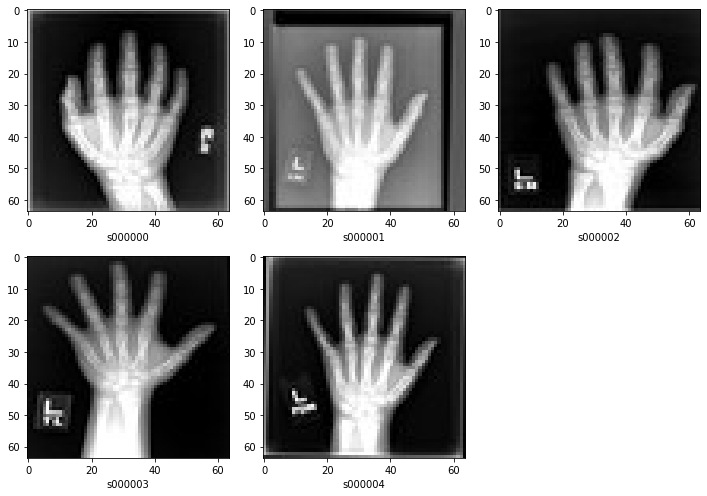

In [52]:
dataset = CSVDataset(
    filename=[filepath1, filepath2, filepath3],
    col_groups={"ehr": [f"ehr_{i}" for i in range(5)]},
    transform=Compose([LoadImaged(keys="image"), ToNumpyd(keys="ehr")]),
)
# test the transformed `ehr` data:
for item in dataset:
    print(type(item["ehr"]), item["ehr"])

# plot the transformed image array
plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    plt.subplot(3, 3, i + 1)
    plt.xlabel(dataset[i]["subject_id"])
    plt.imshow(dataset[i]["image"], cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Load CSV files with `CSVIterableDataset`
`CSVIterableDataset` is designed to load data chunks from very big CSV files, it doesn't need to load all the content at the beginning. And it can support most of above features of `CSVDataset` except for selecting rows.

Here we load CSV files with `CSVIterableDataset` in multi-processing method of DataLoader.

In [63]:
dataset = CSVIterableDataset(filename=[filepath1, filepath2, filepath3])
# set num workers = 0 for mac / win
num_workers = 2 if sys.platform == "linux" else 0
dataloader = DataLoader(dataset=dataset, num_workers=num_workers, batch_size=2)
print(first(dataloader))

{'subject_id': ['s000000', 's000001'], 'label': tensor([5, 0]), 'image': ['/workspace/data/medical/MedNIST/Hand/000000.jpeg', '/workspace/data/medical/MedNIST/Hand/000001.jpeg'], 'ehr_0': tensor([2.0078, 6.8392], dtype=torch.float64), 'ehr_1': tensor([2.2902, 6.4745], dtype=torch.float64), 'ehr_2': tensor([2.0549, 5.8627], dtype=torch.float64), 'ehr_3': tensor([3.0196, 5.1922], dtype=torch.float64), 'ehr_4': tensor([3.8078, 5.2745], dtype=torch.float64), 'ehr_5': tensor([3.5843, 5.2510], dtype=torch.float64), 'ehr_6': tensor([3.1412, 4.6471], dtype=torch.float64), 'ehr_7': tensor([3.1961, 4.8863], dtype=torch.float64), 'ehr_8': tensor([4.2118, 4.3922], dtype=torch.float64), 'ehr_9': tensor([6.3020, 5.2196], dtype=torch.float64), 'ehr_10': tensor([6.4706, 7.8275], dtype=torch.float64), 'meta_0': tensor([ True, False]), 'meta_1': tensor([True, True]), 'meta_2': tensor([ True, False])}


## Cleanup data directory

Remove directory if a temporary was used.

In [14]:
if directory is None:
    shutil.rmtree(root_dir)